#1 Load essential libraries


In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#2 Dataset
##2.1 Downloading Dataset

In [2]:
# Download data
import requests
request = requests.get("https://drive.google.com/uc?export=download&id=1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf")
with open("data.zip", "wb") as file:
    file.write(request.content)

# Unzip data
import zipfile
with zipfile.ZipFile('data.zip') as zip:
    zip.extractall('data')

In [3]:
import os
import glob
import pandas as pd

# Specify the path to the directory where you extracted the zip file
extracted_dir = 'data'  # Change this to the actual directory name if different

# List all CSV files in the extracted directory
csv_files = glob.glob(os.path.join(extracted_dir, '*.csv'))
for csv_file in csv_files:
    print(csv_file)



data/noncomplaint1700.csv
data/test_data.csv
data/complaint1700.csv


In [ ]:
csv_files[0]

'data/complaint1700.csv'

##2.2 Load Train Data
We will load the train data and label it. Because we use only the text data to classify, we will drop unimportant columns and only keep id, tweet and label columns.

In [4]:
combined_train_df = pd.DataFrame()# Create an empty DataFrame to store the combined data
for i in range(0,2):
    df = pd.read_csv(csv_files[i])
    if i==0:
        df['label'] = 1 #label  = 1 for complaints
    else:
        df['label'] = 0 #label  = 0 for non_complaints
    combined_train_df = pd.concat([combined_train_df,df])
print(combined_train_df)# Now you have a single DataFrame 'combined_df' containing data from all CSV

          id    airline                                              tweet  \
0        404     United  @brianfadem @united The best summertime soap o...   
1        706  SouthWest  @aresef @united yes the change fees are cheape...   
2        882  SouthWest  @SouthwestAir Do you guys not fly from Birming...   
3       1196     United  This mornings @united #flight seems to be on t...   
4       1244    JetBlue  @JetBlue @Boston_Calling I have never been to ...   
...      ...        ...                                                ...   
4550  173504  SouthWest  Another day another lie from @SouthwestAir. It...   
4551  173526     United  On @united flight from hell. Diverted from EWR...   
4552  173573     United  @united I will never use your airline after th...   
4553  173599     United  Flight back to SFO delayed over an hour, no up...   
4554  173660    JetBlue  @Jetblue I've been on hold 36 minutes. My flig...   

      label  Unnamed: 0  tid_not_to_be_used           tag  
0  

In [5]:
print(combined_train_df.columns)

Index(['id', 'airline', 'tweet', 'label', 'Unnamed: 0', 'tid_not_to_be_used',
       'tag'],
      dtype='object')


In [6]:
columns_to_drop = ['airline','Unnamed: 0', 'tid_not_to_be_used','tag']
# reshuffle the combined data
combined_train_df = combined_train_df.sample(frac=1).reset_index(drop=True)
combined_train_df.drop(columns=columns_to_drop , inplace = True, axis = 1) # removed airline column
print(combined_train_df)


          id                                              tweet  label
0     131909  @VirginAmerica between that issue and status m...      0
1      24620  It's a sad state of air travel that this is ne...      1
2      18720  @AmericanAir ur the worst, I hate you... I jus...      0
3      70053  @USAirways and @AmericanAir are the worst to d...      0
4     123147  @AmericanAir the bastards still have not got b...      0
...      ...                                                ...    ...
6250   92626  @dougtayek @united   No problem if you're stay...      1
6251  169614  Instagram : by bsumers - One of @americanair's...      0
6252   26533  @AmericanAir what's up with these 20th century...      0
6253   70395  @VirginAmerica your planes and service are awe...      1
6254  158065  @VirginAmerica I had this card in the past, bu...      1

[6255 rows x 3 columns]


##2.3 Splitting data in train and test dataset

In [7]:
from sklearn.model_selection import train_test_split

X = combined_train_df.tweet.values
y = combined_train_df.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

##2.4 Load test dataset

In [8]:
test_data = pd.read_csv(csv_files[2])
# Keep important columns
test_data = test_data[['id', 'tweet']]
# Display 5 samples from the test data
test_data.sample(5)

,id,tweet
1612,28103,Sorry to all on @AmericanAir flight with me. B...
1087,121000,@drewmichael @kylekinane @united the status of...
1677,101323,Who has a private jet and wants to get me?@Ame...
413,20185,.@JetBlue you've lost my friend Sasha as a lo...
159,29168,So disappointed in @SouthwestAir service today...


#3 Setup GPU for training

In [9]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


#4. TF-IDF and Naive Bayes Classifier
In this baseline approach, first we will use TF-IDF to vectorize our text data. Then we will use the Naive Bayes model as our classifier.

 In Scikit-learn's guide to choose the right estimator, it is suggested that Naive Bayes should be used for text data. I also tried using SVD to reduce dimensionality; however, it did not yield a better performance.

##4.1 Data preperation (Preprocessing)

In [10]:
import nltk
# Uncomment to download "stopwords"
# nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

##4.2 TF-IDF Vectorizer

In [12]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(smooth_idf=False) #converts text data to numerical , smooth_idf if TRUE adds 1 to frequency to avoid division by zero error
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 9.84 s, sys: 1.32 s, total: 11.2 s
Wall time: 11.3 s


In [13]:
print(X_train_preprocessed)
print(X_train_tfidf) # outputs a mtrix with (document, word) - tfidf score
#tfidf score represents the importance of that word

['2 hour delay tv ? 5 17 15 flight 153 jfk pbi not cool jetblue'
 'shit need money'
 'delayed delayed delayed canceled southwestairlines southwestair' ...
 'bad run guys lately 3 extreme delays last 3 flights'
 'never plane group 5 mean ?'
 'not sure going told 24hrs ago touch still nothing extremely disappointed']
  (0, 4779)	0.25297711041820975
  (0, 2470)	0.33125891542614894
  (0, 5829)	0.12290837314964728
  (0, 6202)	0.3647148228182602
  (0, 4795)	0.2517998161583937
  (0, 142)	0.4650825449945938
  (0, 3656)	0.11297445203194299
  (0, 137)	0.2978030080340377
  (0, 177)	0.3590298277064018
  (0, 8388)	0.29487685931691543
  (0, 2765)	0.1968729493414427
  (0, 4389)	0.20585972256251048
  (1, 5575)	0.6483548853481895
  (1, 5712)	0.48077334049165343
  (1, 7382)	0.5903329041461544
  (2, 7634)	0.3652379723142267
  (2, 7635)	0.5241698313352265
  (2, 1977)	0.3675706112504886
  (2, 2767)	0.6758247237581164
  (3, 1378)	0.45630224182442436
  (3, 1708)	0.258622278516962
  (3, 4923)	0.23201746061894

##4.3 Training Naive Bayes classifier
We will use cross-validation and AUC score to tune hyperparameters of our model. The function get_auc_CV will return the average AUC score from cross-validation.

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(8, shuffle=True, random_state=1) # 5 folds , shuffles data before splitting in 5 folds, random seed for reproducibility
    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The MultinominalNB class only have one hypterparameter - alpha. The code below will help us find the alpha value that gives us the highest CV AUC score.

Best alpha:  1.0


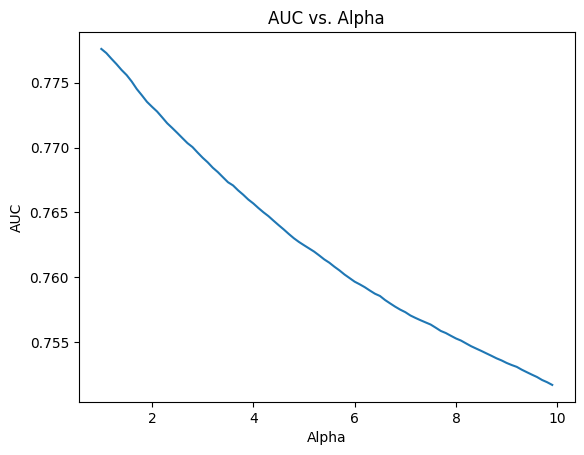

In [17]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
# Create an empty Pandas Series to store AUC scores
res = pd.Series(index=np.arange(1, 10, 0.1), dtype = 'float64')

# Loop through different values of alpha
for i in np.arange(1, 10, 0.1):
    model = MultinomialNB(alpha=i)
    auc = get_auc_CV(model)
    res[i] = auc

# Find the best alpha with the highest AUC
best_alpha = np.round(res.idxmax(), 2)

print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

##4.4 Evaluation on Validation Set
To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set

In [18]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of 74.28% on the validation set. This value is the baseline performance and will be used to evaluate the performance of our fine-tune BERT model.

AUC: 0.7916
Accuracy: 74.28%


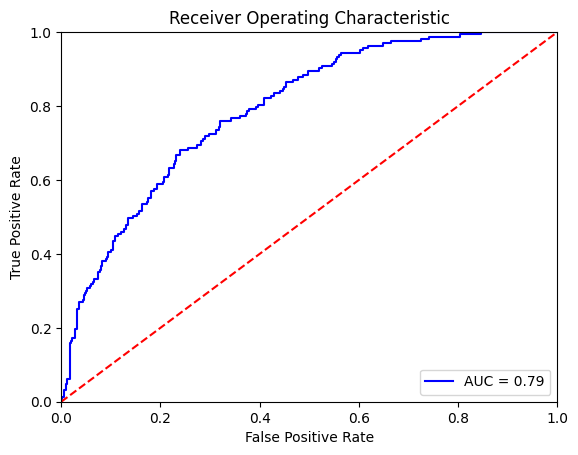

In [19]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

#5. Fine-tuning BERT

##5.1 Installing Hugging face library
The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [20]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.6 MB/s eta 0:00:00


##5.2 Tokenization and Input formatting
Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences

In [21]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [22]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  @VirginAmerica between that issue and status match now being at eight weeks, I've given up on you guys. Nicer planes but not worth it
Processed:  between that issue and status match now being at eight weeks, I've given up on you guys. Nicer planes but not worth it


##5.3 BERT tokenizer
In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special [CLS] and [SEP] tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

In [23]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.

In [24]:
# Concatenate train data and test data
all_tweets = np.concatenate([combined_train_df.tweet.values, test_data.tweet.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  68


Now, Tokenize the data.



In [31]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  @VirginAmerica between that issue and status match now being at eight weeks, I've given up on you guys. Nicer planes but not worth it
Token IDs:  [101, 2090, 2008, 3277, 1998, 3570, 2674, 2085, 2108, 2012, 2809, 3134, 1010, 1045, 1005, 2310, 2445, 2039, 2006, 2017, 4364, 1012, 3835, 2099, 9738, 2021, 2025, 4276, 2009, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


##5.4 Creating PyTorch Dataloader
We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed

In [26]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

##5.5 Train Model
**Create BertClassifier**

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

In [32]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 69.9 ms, sys: 1.99 ms, total: 71.9 ms
Wall time: 75.9 ms


**Optimizer & Learning Rate Scheduler**

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

Batch size: 16 or 32
Learning rate (Adam): 5e-5, 3e-5 or 2e-5
Number of epochs: 2, 3, 4
Huggingface provided the run_glue.py script, an examples of implementing the transformers library. In the script, the AdamW optimizer is used.

In [33]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = torch.optim.AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

**Training Loop**

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:

  * Unpack our data from the dataloader and load the data onto the GPU
  * Zero out gradients calculated in the previous pass
  * Perform a forward pass to compute logits and loss
  * Perform a backward pass to compute gradients (loss.backward())
  * Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
  * Update the model's parameters (optimizer.step())
  * Update the learning rate (scheduler.step())
Evaluation:

  * Unpack our data and load onto the GPU
  * Forward pass
  * Compute loss and accuracy rate over the validation set
  
The script below is commented with the details of our training and evaluation loop.

In [34]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, let's start training our BertClassifier!

In [35]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.605141   |     -      |     -     |   10.45  
   1    |   40    |   0.552723   |     -      |     -     |   6.99   
   1    |   60    |   0.495828   |     -      |     -     |   7.05   
   1    |   80    |   0.458002   |     -      |     -     |   7.15   
   1    |   100   |   0.430170   |     -      |     -     |   7.24   
   1    |   120   |   0.445404   |     -      |     -     |   7.44   
   1    |   140   |   0.434107   |     -      |     -     |   7.51   
   1    |   160   |   0.432232   |     -      |     -     |   7.54   
   1    |   175   |   0.451007   |     -      |     -     |   5.68   
----------------------------------------------------------------------
   1    |    -    |   0.479786   |  0.415592  |   78.18   |   69.74  
---------------------------------------------------------------------

**Evaluation on Validation set**

AUC: 0.9613
Accuracy: 90.89%


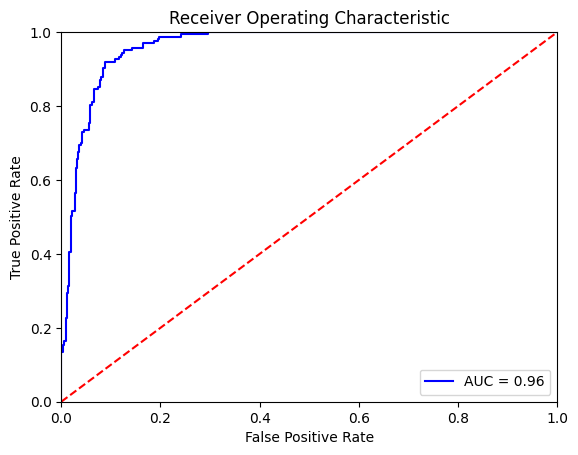

In [41]:
# Compute predicted probabilities on the test set
# Please initialize function `bert_predict` by running the first cell in Section 5.8.
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

##5.6 Train our model on entire training data

In [38]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.578213   |     -      |     -     |   8.46   
   1    |   40    |   0.493376   |     -      |     -     |   8.28   
   1    |   60    |   0.510266   |     -      |     -     |   8.56   
   1    |   80    |   0.466632   |     -      |     -     |   8.47   
   1    |   100   |   0.432622   |     -      |     -     |   8.32   
   1    |   120   |   0.444548   |     -      |     -     |   8.06   
   1    |   140   |   0.494817   |     -      |     -     |   7.99   
   1    |   160   |   0.401252   |     -      |     -     |   7.94   
   1    |   180   |   0.418475   |     -      |     -     |   7.91   
   1    |   195   |   0.460183   |     -      |     -     |   5.81   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapse

##5.7 Predictions on test set

In [39]:
test_data.sample(5)

,id,tweet
1492,142269,We're waiting for a captain for our flight. Se...
115,38591,@JetBlue Thanks but not addressing the issue. ...
135,68080,@AmericanAir has the WORST customer service/re...
352,137507,A #customerservice issue about @DeltaAssist wa...
1302,160133,I am never flying @Delta @DeltaAssist @DeltaNe...


Before making predictions on the test set, we need to redo processing and encoding steps done on the training data. Fortunately, we have written the preprocessing_for_bert function to do that for us.

In [40]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.tweet)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


##5.8 Predictions
The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [36]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [45]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.96
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  35


In [46]:
output = test_data[preds==1]
list(output.sample(20).tweet)

["Ugh I swear I'm only flying @VirginAmerica from now on, American airlines has too many delays ðŸ˜¶",
 'Interesting flight @jetblue. Board &gt; taxi &gt; back to gate &gt; deplane &gt; wait because "the computers" are being replaced ðŸ˜‚',
 '@chermc56 @AmericanAir ughÃ¢â‚¬Â¦ I hate that! Hope you made it to your destination safely!',
 'Southwest cancels customerÃ¢â‚¬â„¢s ticket after he took flight. Another reason why I NEVER fly @SouthwestAir http://t.co/Gj2O2hAsRG',
 'â€œ@DeltaAssist: @Brocantr0 Hi Nick! Have you spoke to our Baggage Service team to set up a delayed baggage claim?  *SBâ€\x9d they were angels tyâ\x9d¤ï¸\x8f',
 'Ã¢â‚¬Å“MinorÃ¢â‚¬Â\x9d H2O valve issue sent 5:40pm ET flight back to gate for fix. Now we return for more fuel because of Ã¢â‚¬Å“weatherÃ¢â‚¬Â\x9d near Lima. cc @JetBlue',
 'Boeing 777 de @AmericanAir aÃƒÂ±adido a la colecciÃƒÂ³n.. #brutal #Aerotrastorno http://t.co/rO6bj61q03',
 '@SouthwestAir Lost 1st Xmas gift my hubby gave me on fl 3505, BWI to DAL yesterd